In [2]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

![image.png](../assets/data_prep_wf.png)

# Raw Data - FER2013
* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* 48 X 48 gray scale images
* 28,709 training samples
* 3,589 validation data
* 3,589 test data
* 7 emotion labels (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
* ~60-65% human accuracy in labelling

![image.png](../assets/test_raw_data.png)

# Data Preparation is Critical
* State of the Art accuracy using a Convolutional Neural Network (CNN) model directly on this raw data is **63%** [1].
* State of the Art accuracy using a slightly modified Convolutional Neural Network (CNN) model after processing the data is **83%** [2].

# Processed Data - FER+

Follow the instructions listed in the README file - https://github.com/TalkAI/facial-emotion-recognition-gluon#before-you-start
* FER+ has new corrected labels
* FER+ has 8 emotions - (0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger', 5: 'disgust', 6: 'fear',7: 'contempt')
* Image augmentations:
    * Crop faces in the images – bounding box in the FER+ dataset
    * Scale image size from 48 X 48 -> 64 X 64
    * Shift image
    * Flip image
    * Rotate (angle) image
    * Normalize the pixels in the image

| Emotion  | Train  | Val  |  Test |
|---|---|---|---|
| neutral  |8733   |  1180 | 1083  |
| happiness  | 7284  | 862  | 892  |
| surprise  | 3136  | 411  | 394  |
| sadness  | 3022  | 348  | 382  |
| anger  | 2098  |  289 |  269 |
| disgust  | 116  | 25  | 16  |
| fear  | 536  | 60  | 86  |
| comtempt  | 120  | 16  | 15  |

In [3]:
# 8 Emotions we want to recognize
emotion_table = {0: 'neutral',
                 1: 'happiness',
                 2: 'surprise',
                 3: 'sadness',
                 4: 'anger',
                 5: 'disgust',
                 6: 'fear',
                 7: 'contempt'}

In [4]:
processed_train_images = np.load('/home/piai/Desktop/ferplus/fer_train_processed_images.npy')
processed_train_labels = np.load('/home/piai/Desktop/ferplus//fer_train_processed_labels.npy')

In [5]:
print(processed_train_images.shape, processed_train_labels.shape)

(25045, 1, 64, 64) (25045, 8)


In [6]:
from matplotlib import pyplot as plt

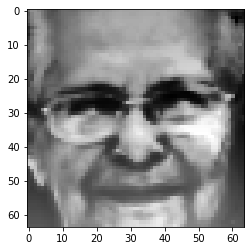

In [7]:
plt.imshow(processed_train_images[987].reshape(64,64), cmap='gray')

In [8]:
processed_test_images = np.load('/home/piai/Desktop/ferplus/fer_test_processed_images.npy')
processed_test_labels = np.load('/home/piai/Desktop/ferplus/fer_test_processed_labels.npy')
processed_val_images = np.load('/home/piai/Desktop/ferplus/fer_val_processed_images.npy')
processed_val_labels = np.load('/home/piai/Desktop/ferplus/fer_val_processed_labels.npy')

In [9]:
print(processed_test_images.shape, processed_test_labels.shape)

(3137, 1, 64, 64) (3137, 8)


In [10]:
print(processed_val_images.shape, processed_val_labels.shape)

(3191, 1, 64, 64) (3191, 8)


In [11]:
# Sets context to GPU, if available. Otherwise sets to CPU.
# Note that training on one GPU takes approx. 1.1 minute per epoch, and may take longer on CPU

ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

![image.png](../assets/model_training_prep_wf.png)

# Step 1 – Construct the Neural Network

### 13 layer VGGNet presented in the paper [2]
![image.png](../assets/network.png)

In [12]:
# We use HybridSequential network type to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net = gluon.nn.HybridSequential()

# Construct 13 layer VGGNet suggested in the paper
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(8))

In [13]:
# We Hybridize the HybridSequential network to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net.hybridize()

# Step 2 – Initialize the parameters in Neural Network

In [14]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
nd.waitall()

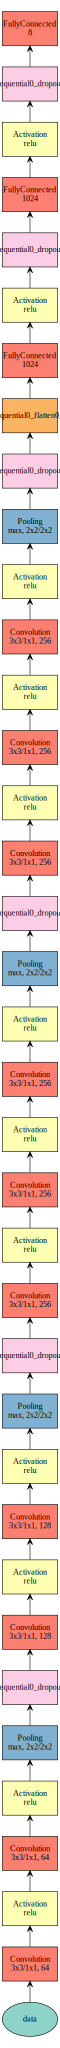

In [15]:
# Use MXBOARD here to visualize network
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)


# Step 3 – Prepare the Trainer with optimizer

In [16]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [17]:
batch_size = 32
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0025, 'momentum': 0.9})

# Step 4 – Prepare the model evaluation strategy

In [18]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

# Step 5 – Prepare data loaders

In [19]:
train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_train_images, train_labels), batch_size = batch_size, shuffle=True)
val_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_val_images, val_labels), batch_size = batch_size)


# Step 6 – Train the Neural Network

In [20]:
epochs = 25

train_accuracies = []
losses = []
val_accuracies = []

for e in range(epochs):
    batch = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
        batch +=1        

    val_accuracy = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    
    losses.append(curr_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" % (e, curr_loss, train_accuracy, val_accuracy))

Epoch 0. Loss: 1.7591823, Train_acc 0.3486923537632262, Val_acc 0.36979003447195236
Epoch 1. Loss: 1.4484231, Train_acc 0.3660211619085646, Val_acc 0.3870260106549671
Epoch 2. Loss: 1.5928266, Train_acc 0.4051108005589938, Val_acc 0.41742400501410215
Epoch 3. Loss: 1.4090112, Train_acc 0.4395687762028349, Val_acc 0.4587903478533375
Epoch 4. Loss: 1.5386918, Train_acc 0.49075663805150727, Val_acc 0.5095581322469446
Epoch 5. Loss: 1.3376462, Train_acc 0.5454182471551208, Val_acc 0.5669069257286117
Epoch 6. Loss: 1.0821584, Train_acc 0.5769614693551607, Val_acc 0.589157004073958
Epoch 7. Loss: 1.2059582, Train_acc 0.6455979237372729, Val_acc 0.6590410529614541
Epoch 8. Loss: 0.8161197, Train_acc 0.6727091235775604, Val_acc 0.6960200564086493
Epoch 9. Loss: 0.9785734, Train_acc 0.7045717708125374, Val_acc 0.7154497022876841
Epoch 10. Loss: 0.85040754, Train_acc 0.7195048911958475, Val_acc 0.72453776245691
Epoch 11. Loss: 0.55289996, Train_acc 0.7430225593930925, Val_acc 0.7380131620181761


# Step 7 - Evaluate on Test Data

In [21]:
# Test accuracy

acc = mx.metric.Accuracy()
test_labels = np.argmax(processed_test_labels, axis=1)
data_iterator = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_test_images, test_labels), batch_size = 32)
for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.argmax(output, axis=1)
    acc.update(preds=predictions, labels=label)
print("Test Accuracy - ", acc.get()[1])

Test Accuracy -  0.7825948358304112


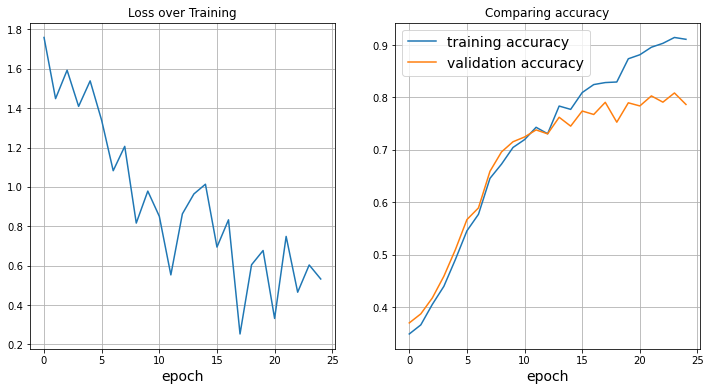

In [22]:
# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

epochs = range(len(train_accuracies))

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(epochs, losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(epochs, train_accuracies)
p2, = fg2.plot(epochs, val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14)

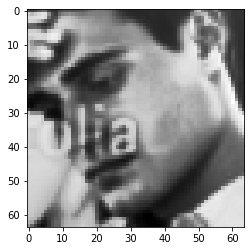

In [23]:
# Example Inference
idx = 98
plt.imshow(processed_test_images[idx].reshape(64,64), cmap='gray')

In [24]:
print("Actual Emotion - ", emotion_table[test_labels[idx]])

Actual Emotion -  sadness


In [25]:
# Perform Inference
output = net(mx.nd.array(processed_test_images[idx].reshape(1,1,64,64)).as_in_context(ctx))

In [26]:
print("Predicted Emotion - ", emotion_table[nd.argmax(output, axis=1).asnumpy()[0]])

Predicted Emotion -  neutral


![image.png](../assets/inference_wf.png)

# Step 8 - Export the model for Production

In [28]:
# Export the model for production deployment.
# There will be 2 files exported: 
# 1) gluon_ferplus-symbol.json => Contains the network definition
# 2) gluon_ferplus-0000.params => Contains the weights in the network
net.export('fer_first')

# Step 9 - Install pre-requisites for model serving

We will need the PyPi packages listed below to test model server locally, and to perform image pre-processing prior to the model inference.

In [ ]:
!pip install mxnet-model-server
!pip install model-archiver
!pip install scikit-image
!pip install opencv-python

# Step 10 - Export a model archive

We will now prepare the model archive, which encapsulates all of the resources required by MMS for serving the model. To learn more about the model archive, visit [MMS Export docs](https://github.com/awslabs/mxnet-model-server/blob/master/docs/export.md).

In [ ]:
# As a first step, we will download the pre-trained model. 
# You can skip this step if you have just trained your model, but then you will need to copy the model files into ferplus directory
!mkdir fer
%cd fer
!curl -O https://s3.amazonaws.com/mxnet-demo-models/models/fer/fer-0000.params
!curl -O https://s3.amazonaws.com/mxnet-demo-models/models/fer/fer-symbol.json

In [2]:
# Now let's pull in and review the other resources needed for the model archive
%cp ../../model_archive_resources/* .

In [ ]:
# We define the model's input and output type and shape via signature.json
!cat signature.json

In [ ]:
# We define the model's class label names via synset.txt
!cat synset.txt

In [ ]:
# And lastly, we define custom code for request handling via python code other auxiliary files
!cat fer_service.py

In [ ]:
# Let's package everything up into a Model Archive bundle
% cd ..
!model-archiver --model-name fer --model-path ./fer --handler fer_service:handle
!ls -l fer.mar

# Step 11 - Serving the model archive with MXNet Model Server

Now that we have the model archive ready, we can start the server and ask it to setup HTTP endpoints to serve the model, emit real-time operational metrics and more.
To learn more about serving, check out the [MMS Serving docs](https://github.com/awslabs/mxnet-model-server/blob/master/docs/server.md).

To start the server and load the FER model on startup, go to the console and run:  
`
$ mxnet-model-server --models fer=fer.mar --model-store .
`

In [ ]:
# Check out the health endpoint to make sure model server is running
!curl http://127.0.0.1:8080/ping

In [ ]:
# Call MMS management API to see list of loaded models
!curl http://localhost:8081/models

In [ ]:
# Query the loaded FER model
!curl http://localhost:8081/models/fer

Now let's make a prediction request with a test image:
![Neutral](../assets/neutral-sad.png)

In [ ]:
!curl -X POST http://127.0.0.1:8080/fer/predict -T "../assets/neutral-sad.png"

Lastly, to stop the server we will go to the console and run:  
`
$ mxnet-model-server --stop
`

# References
1. I. J. Goodfellow, D. Erhan, P. L. Carrier, A. Courville,
M. Mirza, B. Hamner, W. Cukierski, Y. Tang,
D. Thaler, D.-H. Lee, et al. Challenges in
representation learning: A report on three machine
learning contests. In Neural information processing,
pages 117–124. Springer, 2013

2. Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution Emad Barsoum et. al. https://arxiv.org/abs/1608.01041
